# Training in Brax For Humanoid Expert Rendering

Once an environment is created in brax, we can quickly train it using brax's built-in training algorithms. Let's try it out!

In [1]:
%load_ext autoreload
%autoreload 2
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

import mediapy as media
import matplotlib.pyplot as plt

import numpy as np

In [2]:
from brax import actuator
from brax import base
from brax.envs.base import PipelineEnv, State
from brax.io import mjcf
from etils import epath
import jax
from jax import numpy as jp
import mujoco

class Humanoid(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      backend='generalized',
      **kwargs,
  ):
    path = 'assets/humanoid.xml'
    sys = mjcf.load(path)

    n_frames = 5

    if backend in ['spring', 'positional']:
      sys = sys.tree_replace({'opt.timestep': 0.0015})
      n_frames = 10
      gear = jp.array([
          350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0,
          350.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])  # pyformat: disable
      sys = sys.replace(actuator=sys.actuator.replace(gear=gear))

    if backend == 'mjx':
      sys = sys.tree_replace({
          'opt.solver': mujoco.mjtSolver.mjSOL_NEWTON,
          'opt.disableflags': mujoco.mjtDisableBit.mjDSBL_EULERDAMP,
          'opt.iterations': 1,
          'opt.ls_iterations': 4,
      })

    kwargs['n_frames'] = kwargs.get('n_frames', n_frames)

    super().__init__(sys=sys, backend=backend, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jax.Array) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.init_q + jax.random.uniform(
        rng1, (self.sys.q_size(),), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.qd_size(),), minval=low, maxval=hi
    )

    pipeline_state = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(pipeline_state, jp.zeros(self.sys.act_size()))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(pipeline_state, obs, reward, done, metrics)

  def step(self, state: State, action: jax.Array) -> State:
    """Runs one timestep of the environment's dynamics."""

    # Scale action from [-1,1] to actuator limits
    action_min = self.sys.actuator.ctrl_range[:, 0]
    action_max = self.sys.actuator.ctrl_range[:, 1]
    action = (action + 1) * (action_max - action_min) * 0.5 + action_min

    pipeline_state0 = state.pipeline_state
    pipeline_state = self.pipeline_step(pipeline_state0, action)

    com_before, *_ = self._com(pipeline_state0)
    com_after, *_ = self._com(pipeline_state)
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * 0.0001 * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(pipeline_state.x.pos[0, 2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(pipeline_state.x.pos[0, 2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(pipeline_state, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, pipeline_state: base.State, action: jax.Array
  ) -> jax.Array:
    """Observes humanoid body position, velocities, and angles."""
    position = pipeline_state.q
    velocity = pipeline_state.qd

    if self._exclude_current_positions_from_observation:
      position = position[2:]

    com, inertia, mass_sum, x_i = self._com(pipeline_state)
    cinr = x_i.replace(pos=x_i.pos - com).vmap().do(inertia)
    com_inertia = jp.hstack(
        [cinr.i.reshape((cinr.i.shape[0], -1)), inertia.mass[:, None]]
    )

    xd_i = (
        base.Transform.create(pos=x_i.pos - pipeline_state.x.pos)
        .vmap()
        .do(pipeline_state.xd)
    )
    com_vel = inertia.mass[:, None] * xd_i.vel / mass_sum
    com_ang = xd_i.ang
    com_velocity = jp.hstack([com_vel, com_ang])

    qfrc_actuator = actuator.to_tau(
        self.sys, action, pipeline_state.q, pipeline_state.qd)

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        velocity,
        com_inertia.ravel(),
        com_velocity.ravel(),
        qfrc_actuator,
    ])

  def _com(self, pipeline_state: base.State) -> jax.Array:
    inertia = self.sys.link.inertia
    if self.backend in ['spring', 'positional']:
      inertia = inertia.replace(
          i=jax.vmap(jp.diag)(
              jax.vmap(jp.diagonal)(inertia.i)
              ** (1 - self.sys.spring_inertia_scale)
          ),
          mass=inertia.mass ** (1 - self.sys.spring_mass_scale),
      )
    mass_sum = jp.sum(inertia.mass)
    x_i = pipeline_state.x.vmap().do(inertia.transform)
    com = (
        jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
    )
    return com, inertia, mass_sum, x_i  # pytype: disable=bad-return-type  # jax-ndarray

In [3]:
envs.register_environment("humanoid_walk", Humanoid)

First let's pick an environment and a backend to train an agent in. 

Recall from the [Brax Basics](https://github.com/google/brax/blob/main/notebooks/basics.ipynb) colab, that the backend specifies which physics engine to use, each with different trade-offs between physical realism and training throughput/speed. The engines generally decrease in physical realism but increase in speed in the following order: `generalized`,  `positional`, then `spring`.


In [4]:
env_name = 'humanoid_walk'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'mjx'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

# HTML(html.render(env.sys, [state.pipeline_state]))

2024-07-18 17:36:34.847970: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

# Training

Let's train the Ant policy using the `generalized` backend with PPO.

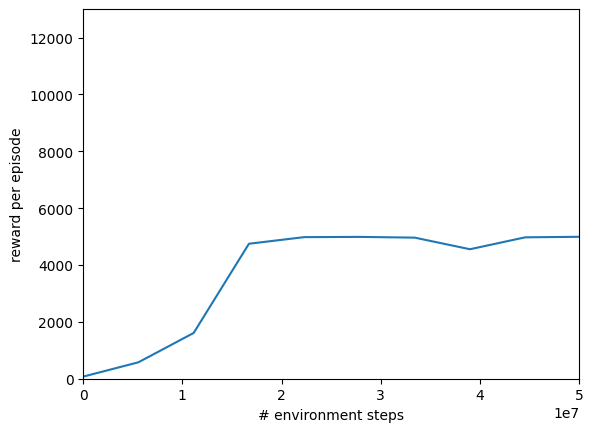

time to jit: 0:00:40.693524
time to train: 0:08:04.237718


In [5]:
# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'inverted_pendulum': functools.partial(ppo.train, num_timesteps=2_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'inverted_double_pendulum': functools.partial(ppo.train, num_timesteps=20_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'ant': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1),
  'humanoid_walk': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
  'reacher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=4, unroll_length=50, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=256, max_devices_per_host=8, seed=1),
  'humanoidstandup': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=15, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=6e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'hopper': functools.partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'walker2d': functools.partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'halfcheetah': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512, seed=3),
  'pusher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=30, num_minibatches=16, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4,entropy_cost=1e-2, num_envs=2048, batch_size=512, seed=3),
}[env_name]

max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid_walk': 13000, 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving Policies

Brax can save and load trained policies:

In [6]:
model.save_params('/tmp/params', params)

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Loading Policies

Brax can save and load trained policies:

In [7]:
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

In [8]:
import mujoco
from tqdm import tqdm

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in tqdm(range(1000)):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, act)

100%|██████████| 1000/1000 [00:26<00:00, 37.54it/s]


In [11]:
# import imageio

# mj_model = mujoco.MjModel.from_xml_path(f"assets/humanoid.xml")

# mj_model.opt.solver = {
#     "cg": mujoco.mjtSolver.mjSOL_CG,
#     "newton": mujoco.mjtSolver.mjSOL_NEWTON,
# }["cg"]

# mj_model.opt.iterations = 6
# mj_model.opt.ls_iterations = 6
# mj_model.opt.jacobian = 0  # dense
# mj_data = mujoco.MjData(mj_model)

# # save rendering and log to wandb
# os.environ["MUJOCO_GL"] = "osmesa"

In [12]:
# mujoco.mj_kinematics(mj_model, mj_data)
# renderer = mujoco.Renderer(mj_model, height=512, width=512)
# qposes_rollout = [data.qpos for data in rollout]

# frames = []

# with imageio.get_writer("output.mp4", fps=30) as video:
#     for qpos1 in qposes_rollout:
#         mj_data.qpos = qpos1
#         mujoco.mj_forward(mj_model, mj_data)
#         renderer.update_scene(mj_data, camera="track")
#         pixels = renderer.render()
#         video.append_data(pixels)
#         frames.append(pixels)

In [21]:
from mocap_preprocess import ReferenceClip, save_dataclass_pickle
import mediapy as media

def add_gaussian_noise_to_control(ctrl, noise_level=0.05):
    noise = jax.random.normal(jax.random.PRNGKey(0), ctrl.shape) * noise_level
    return ctrl + noise

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_env_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 1000
render_every = 1

# TODO: in here, construct a dict with the features that we want from
# state.pipeline_state.qpos/qvel/xpos, using ReferenceClip
qposes = []
qvels = []
xposes = []
coms = []
xquats = []
for i in tqdm(range(n_steps)):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    noisy_ctrl = add_gaussian_noise_to_control(ctrl)
    state = jit_env_step(state, noisy_ctrl)
    data = state.pipeline_state
    rollout.append(data)
    qposes.append(data.qpos)
    qvels.append(data.qvel)
    xposes.append(data.xpos)
    coms.append(data.subtree_com[1])
    xquats.append(data.xquat)
    
    if state.done:
        break

100%|█████████▉| 999/1000 [00:32<00:00, 30.79it/s]


In [22]:
media.show_video(
    env.render(rollout[::render_every], camera="track"), fps=1.0 / env.dt / render_every
)

In [23]:
qposes = np.stack(qposes)
qvels = np.stack(qvels)
xposes = np.stack(xposes)
coms = np.stack(coms)
xquats = np.stack(xquats)

mocap_features = {}
mocap_features["position"] = qposes[:,:3]
mocap_features["quaternion"] = qposes[:,3:7]
mocap_features["joints"] = qposes[:, 7:]
mocap_features["center_of_mass"] = np.reshape(coms, (coms.shape[0], -1))
mocap_features["end_effectors"] = []
mocap_features["velocity"] = qvels[:, :3]
mocap_features["angular_velocity"] = qvels[:, 3:6]
mocap_features["joints_velocity"] = qvels[:, 6:]
mocap_features["appendages"] = []
mocap_features["body_positions"] = xposes
mocap_features["body_quaternions"] = np.reshape(xquats, (xquats.shape[0], -1))

In [24]:
mocap_features['center_of_mass'].shape

(1000, 3)

In [25]:
mocap_features['markers'] = None
mocap_features['scaling'] = None
save_dataclass_pickle("clips/humanoid_walk_slow_traj.p", mocap_features)

/root/talmolab-smb/kaiwen/VNL-Brax-Imitation/mocap_preprocess.py:345: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  data = jax.tree_map(lambda x: jp.array(x), data)


'clips/humanoid_walk_slow_traj.p'

# Standing policy

In [18]:
from brax import actuator
from brax import base
from brax.envs.base import PipelineEnv, State
from brax.io import mjcf
from etils import epath
import jax
from jax import numpy as jp


class HumanoidStandup(PipelineEnv):

  def __init__(self, backend='generalized', **kwargs):
    path = epath.resource_path('brax') / 'envs/assets/humanoidstandup.xml'
    sys = mjcf.load(path)

    n_frames = 5

    if backend in ['spring', 'positional']:
      sys = sys.tree_replace({'opt.timestep': 0.0015})
      n_frames = 10
      sys = sys.replace(
          actuator=sys.actuator.replace(
              gear=jp.array([350.0, 350.0, 350.0, 350.0, 350.0, 350.0,
                             350.0, 350.0, 350.0, 350.0, 350.0, 100.0, 100.0,
                             100.0, 100.0, 100.0, 100.0])))  # pyformat: disable

    kwargs['n_frames'] = kwargs.get('n_frames', n_frames)

    super().__init__(sys=sys, backend=backend, **kwargs)

  def reset(self, rng: jax.Array) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -0.01, 0.01
    qpos = self.sys.init_q + jax.random.uniform(
        rng1, (self.sys.q_size(),), minval=-0.01, maxval=0.01
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.qd_size(),), minval=low, maxval=hi
    )

    pipeline_state = self.pipeline_init(qpos, qvel)
    obs = self._get_obs(pipeline_state, jp.zeros(self.sys.act_size()))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'reward_linup': zero,
        'reward_quadctrl': zero,
    }
    return State(pipeline_state, obs, reward, done, metrics)

  def step(self, state: State, action: jax.Array) -> State:
    """Runs one timestep of the environment's dynamics."""

    # Scale action from [-1,1] to actuator limits
    action_min = self.sys.actuator.ctrl_range[:, 0]
    action_max = self.sys.actuator.ctrl_range[:, 1]
    action = (action + 1) * (action_max - action_min) * 0.5 + action_min

    pipeline_state = self.pipeline_step(state.pipeline_state, action)

    pos_after = pipeline_state.x.pos[0, 2]  # z coordinate of torso
    uph_cost = (pos_after - 0) / self.dt
    quad_ctrl_cost = 0.01 * jp.sum(jp.square(action))
    # quad_impact_cost is not computed here

    obs = self._get_obs(pipeline_state, action)
    reward = uph_cost + 1 - quad_ctrl_cost
    state.metrics.update(reward_linup=uph_cost, reward_quadctrl=-quad_ctrl_cost)

    return state.replace(pipeline_state=pipeline_state, obs=obs, reward=reward)

  def _get_obs(
      self, pipeline_state: base.State, action: jax.Array
  ) -> jax.Array:
    """Observes humanoid body position, velocities, and angles."""
    position = pipeline_state.q[2:]
    velocity = pipeline_state.qd

    com, inertia, mass_sum, x_i = self._com(pipeline_state)
    cinr = x_i.replace(pos=x_i.pos - com).vmap().do(inertia)
    com_inertia = jp.hstack(
        [cinr.i.reshape((cinr.i.shape[0], -1)), inertia.mass[:, None]]
    )

    xd_i = (
        base.Transform.create(pos=x_i.pos - pipeline_state.x.pos)
        .vmap()
        .do(pipeline_state.xd)
    )
    com_vel = inertia.mass[:, None] * xd_i.vel / mass_sum
    com_ang = xd_i.ang
    com_velocity = jp.hstack([com_vel, com_ang])

    qfrc_actuator = actuator.to_tau(
        self.sys, action, pipeline_state.q, pipeline_state.qd)

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        velocity,
        com_inertia.ravel(),
        com_velocity.ravel(),
        qfrc_actuator,
    ])

  def _com(self, pipeline_state: base.State) -> jax.Array:
    inertia = self.sys.link.inertia
    if self.backend in ['spring', 'positional']:
      inertia = inertia.replace(
          i=jax.vmap(jp.diag)(
              jax.vmap(jp.diagonal)(inertia.i)
              ** (1 - self.sys.spring_inertia_scale)
          ),
          mass=inertia.mass ** (1 - self.sys.spring_mass_scale),
      )
    mass_sum = jp.sum(inertia.mass)
    x_i = pipeline_state.x.vmap().do(inertia.transform)
    com = (
        jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
    )
    return com, inertia, mass_sum, x_i  # pytype: disable=bad-return-type  # jax-ndarray

In [19]:
envs.register_environment("humanoid_stand", HumanoidStandup)
env_name = 'humanoid_stand'
backend = 'mjx'
env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

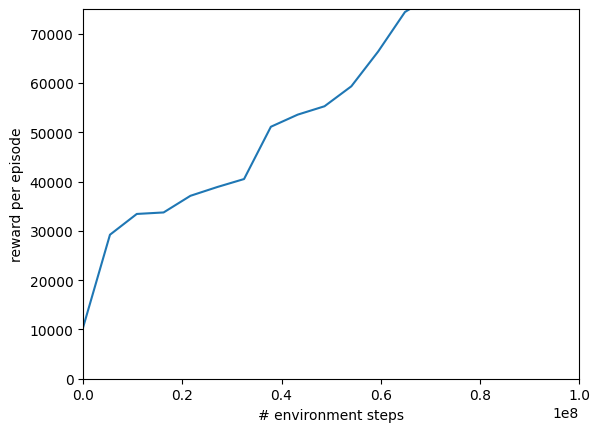

In [20]:
# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'inverted_pendulum': functools.partial(ppo.train, num_timesteps=2_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'inverted_double_pendulum': functools.partial(ppo.train, num_timesteps=20_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'ant': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1),
  'humanoid': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
  'reacher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=4, unroll_length=50, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=256, max_devices_per_host=8, seed=1),
  'humanoid_stand': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=15, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=6e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'hopper': functools.partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'walker2d': functools.partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'halfcheetah': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512, seed=3),
  'pusher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=30, num_minibatches=16, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4,entropy_cost=1e-2, num_envs=2048, batch_size=512, seed=3),
}[env_name]

max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid': 13000, 'humanoid_stand': 75_000, 'reacher': 5, 'walker2d': 5000, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

In [ ]:
from mocap_preprocess import ReferenceClip, save_dataclass_pickle
import mediapy as media

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_env_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 1000
render_every = 1

# TODO: in here, construct a dict with the features that we want from
# state.pipeline_state.qpos/qvel/xpos, using ReferenceClip
qposes = []
qvels = []
xposes = []
coms = []
xquats = []
for i in tqdm(range(n_steps)):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, ctrl)
    data = state.pipeline_state
    rollout.append(data)
    qposes.append(data.qpos)
    qvels.append(data.qvel)
    xposes.append(data.xpos)
    coms.append(data.subtree_com[1])
    xquats.append(data.xquat)
    if state.done:
        break

In [ ]:
media.show_video(
    env.render(rollout[::render_every], camera="track"), fps=1.0 / env.dt / render_every
)

In [ ]:
qposes = np.stack(qposes)
qvels = np.stack(qvels)
xposes = np.stack(xposes)
coms = np.stack(coms)
xquats = np.stack(xquats)

mocap_features = {}
mocap_features["position"] = qposes[:,:3]
mocap_features["quaternion"] = qposes[:,3:7]
mocap_features["joints"] = qposes[:, 7:]
mocap_features["center_of_mass"] = np.reshape(coms, (coms.shape[0], -1))
mocap_features["end_effectors"] = []
mocap_features["velocity"] = qvels[:, :3]
mocap_features["angular_velocity"] = qvels[:, 3:6]
mocap_features["joints_velocity"] = qvels[:, 6:]
mocap_features["appendages"] = []
mocap_features["body_positions"] = xposes
mocap_features["body_quaternions"] = np.reshape(xquats, (xquats.shape[0], -1))

In [ ]:
mocap_features['center_of_mass'].shape

In [ ]:
mocap_features['markers'] = None
mocap_features['scaling'] = None
save_dataclass_pickle("clips/humanoid_stand_traj.p", mocap_features)